Data Generation

In [1]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 4.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import zipfile
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [3]:
# Parameters
patients = 5
channels_per_series = 750
time_points = 10240  # 20 seconds at 512 Hz
sampling_rate = 512  # Hz

# Time array
time = np.linspace(0, 20, time_points)  # 20 seconds

# Function to generate synthetic signals
def generate_focal_signal(time, noise_level=0.5):
    """Generate synthetic focal signal (seizure-like)."""
    base_signal = 3 * np.sin(2 * np.pi * 10 * time)  # High frequency component (10 Hz)
    noise = noise_level * np.random.normal(size=len(time))  # Random noise
    return base_signal + noise

def generate_nonfocal_signal(time, noise_level=0.2):
    """Generate synthetic nonfocal signal (healthy-like)."""
    base_signal = np.sin(2 * np.pi * 2 * time)  # Low frequency component (2 Hz)
    noise = noise_level * np.random.normal(size=len(time))  # Random noise
    return base_signal + noise

# Generate synthetic data
synthetic_data = {}

for patient in range(1, patients + 1):
    patient_data = {"F_series": [], "N_series": []}

    for channel in range(channels_per_series):
        # Focal series (F-series)
        focal_x = generate_focal_signal(time)
        focal_y = focal_x * 0.8 + np.random.normal(0, 0.3, size=len(time))
        patient_data["F_series"].append((focal_x, focal_y))

        # Nonfocal series (N-series)
        nonfocal_x = generate_nonfocal_signal(time)
        nonfocal_y = nonfocal_x * 0.9 + np.random.normal(0, 0.1, size=len(time))
        patient_data["N_series"].append((nonfocal_x, nonfocal_y))

    synthetic_data[f"Patient_{patient}"] = patient_data

# Data is stored in the `synthetic_data` dictionary


In [4]:
# Get data for Patient 1
patient_1_data = synthetic_data["Patient_1"]

# Get focal signal for the first channel of Patient 1
focal_x, focal_y = patient_1_data["F_series"][0]

# Get nonfocal signal for the first channel of Patient 1
nonfocal_x, nonfocal_y = patient_1_data["N_series"][0]

Visualization

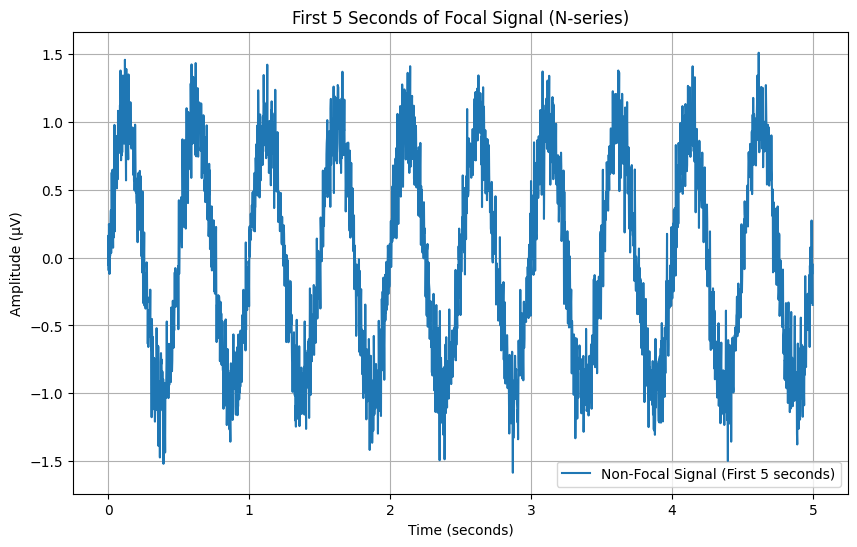

In [6]:
patient_data = synthetic_data["Patient_1"]
nonfocal_signal_first_ch = patient_data["N_series"][0]
nonfocal_signal_x = nonfocal_signal_first_ch[0]

# Select the first 5 seconds (5 seconds = 5 * 512 samples)
time_5s = time[:5 * sampling_rate]  # First 5 seconds
focal_signal_5s = nonfocal_signal_x[:5 * sampling_rate]

# Plot the first 5 seconds of the focal signal (F-series)
plt.figure(figsize=(10, 6))
plt.plot(time_5s, focal_signal_5s, label="Non-Focal Signal (First 5 seconds)")
plt.title("First 5 Seconds of Focal Signal (N-series)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True)
plt.show()

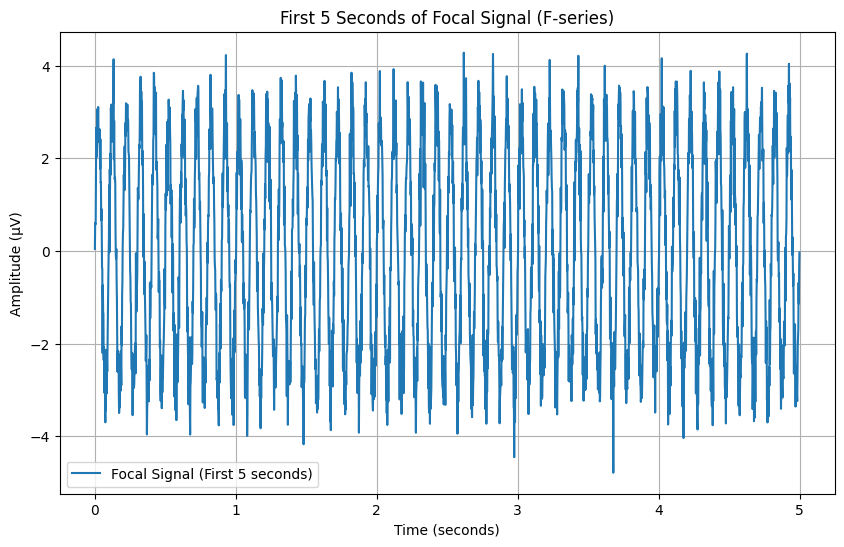

In [7]:
patient_data = synthetic_data["Patient_1"]
focal_signal_first_ch = patient_data["F_series"][0]
focal_signal_x = focal_signal_first_ch[0]

# Select the first 5 seconds (5 seconds = 5 * 512 samples)
time_5s = time[:5 * sampling_rate]  # First 5 seconds
focal_signal_5s = focal_signal_x[:5 * sampling_rate]

# Plot the first 5 seconds of the focal signal (F-series)
plt.figure(figsize=(10, 6))
plt.plot(time_5s, focal_signal_5s, label="Focal Signal (First 5 seconds)")
plt.title("First 5 Seconds of Focal Signal (F-series)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.grid(True)
plt.show()

HMM Model

In [11]:
# Initialize an array to hold all observed data from all patients
train_data = []

# Loop through the synthetic data for 4 patients
for patient_idx in range(1, patients):  # Iterating through 4 patients
    # Get the F-series (focal signals) for each patient
    patient_data = synthetic_data[f"Patient_{patient_idx}"]

    # For simplicity, we'll use the 'focal_x' signal from each channel
    # Extract 'focal_x' from each channel in the patient's F-series
    # 'patient_data["F_series"]' is a list of tuples: (focal_x, focal_y)
    for channel_data in patient_data["F_series"]:
        focal_x = channel_data[0]  # Extract focal_x (first element of the tuple)
        train_data.append(focal_x)  # Add focal_x to the observed data list

# Combine the data from all patients into a single array for fitting
combined_data = np.concatenate(train_data)  # Concatenate all patient data into one array

# Reshape the data to fit the HMM (HMM expects 2D data: samples x features)
combined_data_reshaped = combined_data.reshape(-1, 1)

# Fit the HMM model



In [15]:
len(combined_data_reshaped)

30720000

In [16]:
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)

# Fit the model to the combined data
model.fit(combined_data_reshaped[:1000000])

# Now, the model is trained and can be used for decoding sequences or inference
print("HMM training completed.")

HMM training completed.


In [17]:
test_data = []

patient_data_test = synthetic_data[f"Patient_5"]
# For simplicity, we'll use the 'focal_x' signal from each channel
# Extract 'focal_x' from each channel in the patient's F-series
# 'patient_data["F_series"]' is a list of tuples: (focal_x, focal_y)

for channel_data in patient_data_test["F_series"]:
    focal_x = channel_data[0]  # Extract focal_x (first element of the tuple)
    test_data.append(focal_x)  # Add focal_x to the observed data list

test_data = np.array(test_data)

# Reshape the test data to fit the HMM (HMM expects 2D: samples x features)
test_data_reshaped = test_data.T  # Transpose to match (time_steps x channels) if needed

# Check the shape to ensure it's correct (should be time_steps x channels)
print(test_data_reshaped.shape)

(10240, 750)


In [18]:
predicted_states = model.predict(test_data_reshaped)

In [19]:
predicted_states

array([2, 2, 2, ..., 2, 2, 2])

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_reshaped, label="Test Signal", color="blue", alpha=0.7)
plt.scatter(range(len(test_data_reshaped)), test_data_reshaped, c=predicted_states, cmap="viridis", label="Predicted States", s=10)
plt.title("Test Signal with Predicted Hidden States")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.colorbar(label="State")
plt.show()


ValueError: x and y must be the same size

Error in callback <function _draw_all_if_interactive at 0x7968192524d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7968192511b0> (for post_execute):


KeyboardInterrupt: 